In [1]:
!python3.6 -m pip install tensorboardX torch librosa tqdm lws wavenet_vocoder
!apt-get install libsndfile1 --yes

     |████████████████████████████████| 204kB 1.0MB/s eta 0:00:01
     |████████████████████████████████| 753.4MB 125kB/s  eta 0:00:01    |██▏                             | 51.6MB 10.6MB/s eta 0:01:07███████████████████████▋      | 601.8MB 12.2MB/s eta 0:00:13
     |████████████████████████████████| 1.6MB 12.0MB/s eta 0:00:01
     |████████████████████████████████| 61kB 16.4MB/s eta 0:00:01
     |████████████████████████████████| 153kB 13.0MB/s eta 0:00:01
     |████████████████████████████████| 26.1MB 12.2MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 13.1MB/s eta 0:00:01
     |████████████████████████████████| 296kB 10.6MB/s eta 0:00:01
     |████████████████████████████████| 327kB 15.4MB/s eta 0:00:01
     |████████████████████████████████| 3.7MB 13.4MB/s eta 0:00:01   |██▍                             | 266kB 13.4MB/s eta 0:00:01
     |████████████████████████████████| 20.2MB 12.2MB/s eta 0:00:01
     |████████████████████████████████| 399kB 13.0MB/s eta 0:00:01
    

Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libogg0 amd64 1.3.2-1 [17.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libflac8 amd64 1.3.2-1 [213 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libvorbis0a amd64 1.3.5-4.2 [86.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libvorbisenc2 amd64 1.3.5-4.2 [70.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libsndfile1 amd64 1.0.28-4ubuntu0.18.04.1 [170 kB]
Fetched 557 kB in 0s (1178 kB/s)    
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libogg0:amd64.
(Reading database ... 15402 files and directories currently installed.)
Preparing to unpack .../libogg0_1.3.2-1_amd64.deb ...
Unpacking libogg0:amd64 (1.3.2-1) ...
Selecting previously unselected package libflac8:amd64.
Preparing to unpack .../libflac8_1.3.2-1_amd64.deb ...
Unpacking libflac8:amd64 (1.3.2-1) ...
Selecting previously unselected pa

# Train

In [5]:
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import pickle
from utils import Hps
from utils import DataLoader
from utils import Logger
from utils import SingleDataset
from solver import Solver
import argparse
%matplotlib inline

args_load_model=False
args_flag='train'
args_hps_path="vctk.json"
args_dataset_path_trg="vctk_old/data-wavenet.h5"
args_dataset_path="vctk_old/data-8-wavenet.h5"
args_index_path_trg="vctk_old/index-wavenet.json"
args_index_path="vctk_old/index-wavenet.json"
args_output_model_path="model_vctk/model_vctk"
args_load_model_path="model_vctk/model_vctk-62000"
wavenet_mel=True

hps = Hps()
hps.load(args_hps_path)
hps_tuple = hps.get_tuple()
dataset = SingleDataset(args_dataset_path, args_index_path, seg_len=hps_tuple.seg_len)
dataset_trg = SingleDataset(args_dataset_path_trg, args_index_path_trg, seg_len=hps_tuple.seg_len)
data_loader = DataLoader(dataset, dataset_trg)

solver = Solver(hps_tuple, data_loader, wavenet_mel)
if args_load_model:
    solver.load_model(args_load_model_path)

solver.train(args_output_model_path, args_flag, mode='pretrain_G')
solver.train(args_output_model_path, args_flag, mode='pretrain_D')
solver.train(args_output_model_path, args_flag, mode='train')
solver.train(args_output_model_path, args_flag, mode='patchGAN')

pre_G:[000001/008000], loss_rec=0.465
pre_G:[000002/008000], loss_rec=0.438
pre_G:[000003/008000], loss_rec=0.388
pre_G:[000004/008000], loss_rec=0.361
pre_G:[000005/008000], loss_rec=0.343
pre_G:[000006/008000], loss_rec=0.302
pre_G:[000007/008000], loss_rec=0.285
pre_G:[000008/008000], loss_rec=0.281
pre_G:[000009/008000], loss_rec=0.259
pre_G:[000010/008000], loss_rec=0.264
pre_G:[000011/008000], loss_rec=0.245
pre_G:[000012/008000], loss_rec=0.238
pre_G:[000013/008000], loss_rec=0.238
pre_G:[000014/008000], loss_rec=0.223
pre_G:[000015/008000], loss_rec=0.223
pre_G:[000016/008000], loss_rec=0.220
pre_G:[000017/008000], loss_rec=0.205
pre_G:[000018/008000], loss_rec=0.206
pre_G:[000019/008000], loss_rec=0.202
pre_G:[000020/008000], loss_rec=0.199
pre_G:[000021/008000], loss_rec=0.201
pre_G:[000022/008000], loss_rec=0.192
pre_G:[000023/008000], loss_rec=0.191
pre_G:[000024/008000], loss_rec=0.183
pre_G:[000025/008000], loss_rec=0.191
pre_G:[000026/008000], loss_rec=0.187
pre_G:[00002

KeyboardInterrupt: 

# Single file decompression

load model from model_vctk/lin_dec/model_vctk-80000
(513, 219) (513, 222)


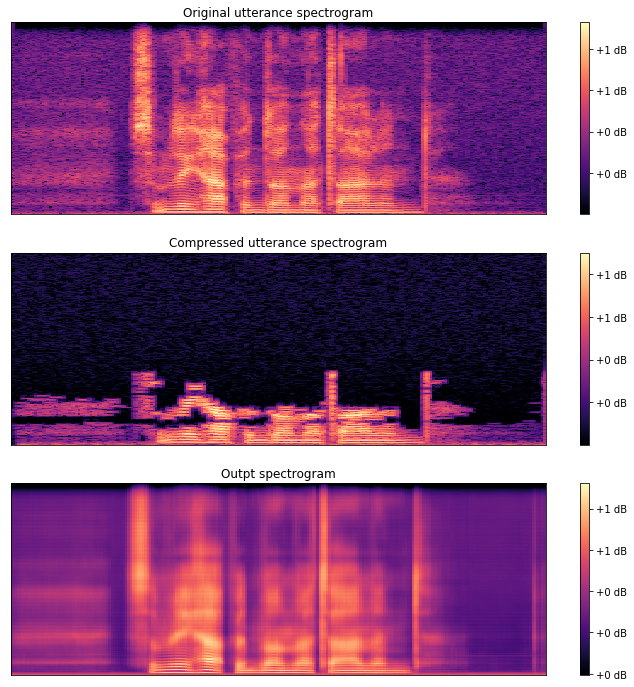

In [12]:
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import pickle
from utils import Hps
from preprocess.tacotron.norm_utils import spectrogram2wav, get_spectrogram
from scipy.io.wavfile import write
import glob
import os
from solver import Solver
import librosa
import librosa.display
from plots import plot
%matplotlib inline

args_hps='vctk.json'
args_model="model_vctk/lin_dec/model_vctk-80000"
args_source="test/p270_462.wav"
args_source_8="test/p270_462-8.wav"
args_target=18
args_output="test/output.wav"
args_sample_rate=16000
args_use_gen=False
wavenet_mel=False

hps = Hps()
hps.load(args_hps)
hps_tuple = hps.get_tuple()
solver = Solver(hps_tuple, None, wavenet_mel=wavenet_mel)
solver.load_model(args_model)
spec = get_spectrogram(args_source, wavenet_mel)
spec_8 = get_spectrogram(args_source_8, wavenet_mel)

spec_expand = np.expand_dims(spec_8, axis=0)
spec_tensor = torch.from_numpy(spec_expand).type(torch.FloatTensor)
c = Variable(torch.from_numpy(np.array([int(args_target)]))).cuda()
result = solver.test_step(spec_tensor, c, gen=args_use_gen)
result = result.squeeze(axis=0).transpose((1, 0))
if not wavenet_mel:
    wav_data = spectrogram2wav(result)
    write(args_output, rate=args_sample_rate, data=wav_data)

plot(spec.T, spec_8.T, result.T)

# WaveNet synthesis

In [6]:
import torch
import librosa
import pickle
from vocoder.synthesis import build_model
from vocoder.synthesis import wavegen
import numpy as np

spect=result

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = build_model().to(device)
checkpoint = torch.load("autovc_wavenet_checkpoint_step001000000_ema.pth", map_location=device)
model.load_state_dict(checkpoint["state_dict"])

waveform = wavegen(model, c=spect)   
librosa.output.write_wav('test/output_wavenet'+'.wav', waveform, sr=16000)

100%|██████████| 47104/47104 [07:04<00:00, 110.89it/s]
